## Updating all packages

In [ ]:
import pkg_resources
from subprocess import call

packages = [dist.project_name for dist in pkg_resources.working_set]
call("pip install --upgrade " + ' '.join(packages), shell=True)


## Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook as tqdm
from spellchecker import SpellChecker
import string  
import re
import nltk
#nltk.download('punkt')
#nltk.download('stopwords')

## Preprocessing Tweets

In [2]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
def preprocess_tweet(text):

    
    
    # convert text to lower-case
    nopunc=text
    nopunc = nopunc.lower()
    #print("Lowered ",nopunc)
    
    # remove URLs
    nopunc = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))', '', nopunc)
    nopunc = re.sub(r'http\S+', '', nopunc)
    #print("URLs Removed -",nopunc)
    
    # remove usernames
    nopunc = re.sub('@[^\s]+', '', nopunc)
    #print("Usernames Removed -",nopunc)
    
    # remove the # in #hashtag
    nopunc = re.sub(r'#([^\s]+)', r'\1', nopunc)
    #print("Hashtags Removed -",nopunc)
    
    # Check characters to see if they are in punctuation
    txt=nopunc
    nopunc = [char for char in txt if char not in string.punctuation]
    #print("No punc ",nopunc)
    
    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    #print("Puntuation Removed -",nopunc)
    
    # remove repeated characters
    nopunc = word_tokenize(nopunc)
    
    # remove stopwords from final word list
    ar= [word for word in nopunc if word not in stopwords.words('english')]
    return ' '.join(ar)

In [10]:
sub="@john@pravash Prayers, For Nepalll!!! http://t.co/XYZ #Nepal #Earthquake"
print("Raw tweet -",sub)
print("Filtered tweet -",preprocess_tweet(sub))

Raw tweet - @john@pravash Prayers, For Nepalll!!! http://t.co/XYZ #Nepal #Earthquake
URLs Removed - @john@pravash prayers, for nepalll!!!  #nepal #earthquake
Usernames Removed -  prayers, for nepalll!!!  #nepal #earthquake
Hashtags Removed -  prayers, for nepalll!!!  nepal earthquake
Puntuation Removed -  prayers for nepalll  nepal earthquake
Filtered tweet - prayers nepalll nepal earthquake


In [11]:
sp=SpellChecker()


['rt', 'woman', 'shouldnt', 'complain', 'cleaning', 'house', 'amp', 'man', 'always', 'take', 'trash']


## Loading GloVe Vectors(50d) and creating a word2vec Dictionary

In [3]:
glove=pd.read_csv("glove.6B\\new.txt",encoding="utf8")
embeddings={}
for i,ser in glove.iterrows():
    vectors=""
    c=0
    for x in ser:
        if(c>0):
            vectors=vectors+str(x)+","
        c+=1
    vectors=vectors[:-1]
    embeddings[ser.Words]=vectors
corpus=set(embeddings.keys())

## Helper function to convert tweets into numpy array of 50d vectors
### We will use this function to get X_train and X_test

In [5]:
def get_vec_representation_of_tweets(df):
    X=np.array([[]])
    import re
    for i,row in df.iterrows():
        st=re.split(r'[;,.\s]\s*',row["tweet"])
        cnt,total=[0,0]
        vector=np.zeros(50)
        for word in st:
            total=total+1
            if len(word)>0 and word in corpus:
                cnt=cnt+1
                get_vector=np.array(list(map(np.float,embeddings[word].split(","))))
                vector=vector+get_vector
        vector=vector/cnt
        if X.shape[1]==0:
            X=np.append(X,[vector],axis=1)
        else:
            X=np.append(X,[vector],axis=0)
    return X

## Loading Datasets and converting them to torch tensors

In [6]:
df=pd.read_csv(r'filtered_tweet.csv',sep=',',names=["tweet","class"])

## Further Preprocessing
### Removing more StopWords and words less than length 3

In [7]:

def further_preprocess(x):
    x=x.split()
    ls=[]
    for wrd in x:
        if(len(wrd)>2):
            ls.append(wrd)
    return ' '.join(ls)

#print(further_preprocess("rt boy dats coldtyga dwn bad cuffin dat hoe 1st place"))

In [8]:
df["tweet"]=df.tweet.apply(further_preprocess)

In [ ]:
#df['class']=df["class"].apply(lambda x: 1 if(x==1 or x==0) else 2 )
#df['class']=df["class"].apply(lambda x: 0 if(x==2) else 1)

In [9]:
df["class"].value_counts(normalize=True)*len(df)

1    19190.0
2     4163.0
0     1430.0
Name: class, dtype: float64

In [9]:
pd.set_option('display.max_colwidth', -1)
df[df["class"]==1].head(5)

C:\Users\Pravash Ranjan\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


,tweet,class
1,boy dats coldtyga dwn bad cuffin dat hoe 1st place,1
2,dawg ever fuck bitch start cry confused shit,1
3,look like tranny,1
4,shit hear might true might faker bitch told 57361,1
5,shit blows meclaim faithful somebody still fucking hoes 128514128514128514,1


In [10]:
hate=df[(df["class"]==1) | (df["class"]==0)]
non_hate=df[df["class"]==2]
print(len(hate),len(non_hate))

20620 4163


In [11]:
non_hate.head(10)

,tweet,class
0,woman shouldnt complain cleaning house amp man always take trash,2
40,momma said pussy cats inside doghouse,2
63,simplyaddictedtoguys woof woof hot scally lad,2
66,woof woof hot soles,2
67,lemmie eat oreo amp dishes one oreo lol,2
70,eggplant emoji doey say looked like scream lmao,2
75,baby monkey bathtime awwwwe soooo adorable,2
115,baseball season win yankees love started,2
118,early bird night owl wise worms,2
119,overdosing heavy drugs doesnt sound bad tonight pussy shit every day,2


In [11]:
hate_speech_freq={}
hate_speech_set=set()
for i,row in tqdm(hate.iterrows()):
    tokens=row["tweet"].split()
    #print(i,tokens)
    for tkn in tokens:
        if(tkn not in hate_speech_set):
            hate_speech_freq[tkn]=1
            hate_speech_set.add(tkn)
        else:
            cnt=hate_speech_freq[tkn]+1
            hate_speech_freq[tkn]=cnt
    

C:\Users\Pravash Ranjan\anaconda3\lib\site-packages\ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


In [12]:
sorted_hate_dict = sorted(hate_speech_freq.items(), key=lambda x: x[1],reverse=True)
print(type(sorted_hate_dict))
for key in sorted_hate_dict:
    print(key)
    if(key[1]<500):
        break


<class 'list'>
('bitch', 8112)
('bitches', 3045)
('like', 2459)
('hoes', 2318)
('pussy', 2066)
('hoe', 1836)
('dont', 1580)
('ass', 1560)
('got', 1467)
('8220', 1452)
('fuck', 1406)
('get', 1284)
('shit', 1245)
('nigga', 1191)
('aint', 1119)
('lol', 893)
('niggas', 788)
('know', 716)
('amp', 673)
('fucking', 626)
('yall', 616)
('love', 611)
('cant', 587)
('one', 567)
('thats', 533)
('bad', 532)
('want', 498)


In [ ]:
!pip install wordcloud

In [ ]:
hate_speech_freq["man"]

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt 
import pandas as pd 
  
# Reads 'Youtube04-Eminem.csv' file  
#df = pd.read_csv(r"Youtube04-Eminem.csv", encoding ="latin-1") 
  
comment_words = '' 

  
# iterate through the csv file 
for val in tqdm(hate.tweet): 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
    #print(comment_words)
    #break
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = StopWords, 
                min_font_size = 10).generate(comment_words) 

# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 


## Preparing Test and Train Dataset

In [13]:
print(len(hate),len(non_hate))
train=hate[0:6000]
train_final=pd.concat([train,non_hate[0:3000]])
test=hate[6001:10001]
test_final=pd.concat([test,non_hate[3000:]])

20620 4163


In [14]:
print(train_final["class"].value_counts())
print(test_final["class"].value_counts())

1    5378
2    3000
0     622
Name: class, dtype: int64
1    3764
2    1163
0     236
Name: class, dtype: int64


In [15]:
train_final["class"].replace(0,1,inplace=True)
train_final["class"].replace(2,0,inplace=True)
test_final["class"].replace(0,1,inplace=True)
test_final["class"].replace(2,0,inplace=True)
print(train_final["class"].value_counts())
print(test_final["class"].value_counts())

1    6000
0    3000
Name: class, dtype: int64
1    4000
0    1163
Name: class, dtype: int64


In [ ]:
train_final.head(10)

In [16]:
from sklearn.utils import shuffle
train_final = shuffle(train_final)
train_final.head(10)

,tweet,class
904,pornandroidiphoneipadsexxxx xxx homemade pussy...,1
675,bitchslapthursdays 2nite pure passion doors op...,1
6048,stay safe charlie,0
4498,bitch,1
16096,buy tickets transformers lock aluminum trash t...,0
3355,direct flight price done layovers flying bitch...,1
4504,man wilson 2nd black win chip talkn trash talk...,0
2190,klains real sole job dampen mushrooming bad po...,0
3915,get real hair cut faggot served country marine...,1
827,boom bitches,1


In [17]:
X_train=get_vec_representation_of_tweets(train_final)
y_train=train_final["class"].values
y_train=y_train.astype(np.float32)
X_test=get_vec_representation_of_tweets(test_final)
y_test=test_final["class"].values
y_test=y_test.astype(np.float32)

C:\Users\Pravash Ranjan\anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train=scaler.transform(X_train)
X_test=scaler.transform(X_test)

In [18]:
X_train[X_train!=X_train]=0.0
X_test[X_test!=X_test]=0.0

In [19]:
import torch
X_train_tensor=torch.from_numpy(X_train)
y_train_tensor=torch.from_numpy(y_train)

X_test_tensor=torch.from_numpy(X_test)
y_test_tensor=torch.from_numpy(y_test)

y_train_tensor=torch.reshape(y_train_tensor,(y_train_tensor.shape[0],1))
y_test_tensor=torch.reshape(y_test_tensor,(y_test_tensor.shape[0],1))

## Deel Learning Model
## Neural Network

In [67]:
import torch.nn as nn
class FirstNetwork_v2(nn.Module):
    
    def __init__(self):
        super().__init__()
        torch.manual_seed(0)
        self.lin1 = nn.Linear(50, 1000)        
        self.lin2 = nn.Linear(1000, 100)
        self.lin3 = nn.Linear(100, 1)
        

    def forward(self, X):
        a1=self.lin1(X)
        h1=a1.sigmoid()
        a2=self.lin2(h1)
        h2=a2.sigmoid()
        a3=self.lin3(h2)
        h3=a3.sigmoid()
        
        return h3
def fit_v2(x, y, model, opt, loss_fn, epochs = 1,batch_size=30):
    ls=[]
    #net = net.float()
    train=[]
    test=[]
    no_of_batches=9000//batch_size
    for epoch in tqdm(range(epochs)):
        for i in range(no_of_batches):
            X_batch=x[i*batch_size:i*batch_size+batch_size,:]
            y_batch=y[i*batch_size:i*batch_size+batch_size,:]
            md=fn(X_batch.float())
            #print(md)
            #print(y)

            loss = loss_fn(md, y_batch)

            #print(i,loss)
            #ls.append(loss.item())
            loss.backward()
            opt.step()
            opt.zero_grad()
        ls.append(loss.item())        
        train.append(((fn(X_train_tensor.float())>0.5).type(torch.int)==y_train_tensor).sum().item()/y_train.shape[0]*100)
        test.append(((fn(X_test_tensor.float())>0.5).type(torch.int)==y_test_tensor).sum().item()/y_test.shape[0]*100)
        opt.zero_grad()
    print("Network: [50,100,100,1] , Loss fn: MSE , Optimizer: Adam , LR: 0.001 , Epochs: 500 , Batch_size= 9000")
    plt.plot(train,color="blue",label='Training Accuracy')
    plt.plot(test,color="red",label='Testing Accuracy')
    plt.xlabel("epochs")
    plt.ylabel("Accuracy")
    plt.legend(loc="best")
    plt.show()    
    return ls

torch.Size([9000, 50]) torch.Size([9000, 1])


C:\Users\Pravash Ranjan\anaconda3\lib\site-packages\ipykernel_launcher.py:27: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Network: [50,100,100,1] , Loss fn: MSE , Optimizer: Adam , LR: 0.001 , Epochs: 500 , Batch_size= 9000


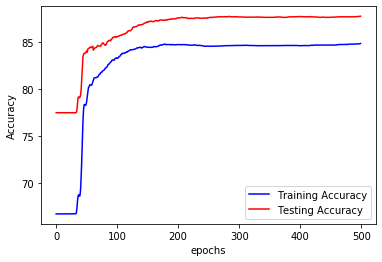

Network: [50,100,100,1] , Loss fn: MSE , Optimizer: Adam , LR: 0.001 , Epochs: 500 , Batch_size= 9000


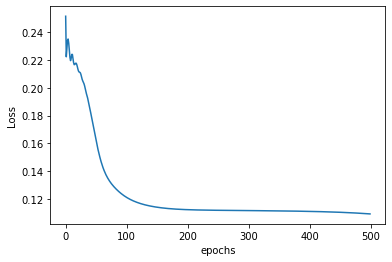

<Figure size 1080x1080 with 0 Axes>

In [68]:
import torch.nn.functional as F
from torch import optim
print(X_train_tensor.shape,y_train_tensor.shape)
fn = FirstNetwork_v2()
loss_fn = [nn.BCELoss(),F.mse_loss]
opt = optim.Adam(fn.parameters(), lr=.001)
ls=fit_v2(X_train_tensor, y_train_tensor, fn, opt, loss_fn[1],epochs=500,batch_size=9000)
print("Network: [50,100,100,1] , Loss fn: MSE , Optimizer: Adam , LR: 0.001 , Epochs: 500 , Batch_size= 9000")
plt.plot(ls)
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.figure(figsize=(15,15))
plt.show()

In [69]:
#Train Accuracy
((fn(X_train_tensor.float())>0.5).type(torch.int)==y_train_tensor).sum().item()/y_train.shape[0]*100

84.86666666666667

In [70]:
#Test Accuracy
((fn(X_test_tensor.float())>0.5).type(torch.int)==y_test_tensor).sum().item()/y_test.shape[0]*100

87.77842339724967

## Testing Model with user inputs

In [29]:
import re
def get_vec_for_senten(s):
    st=re.split(r'[;,.\s]\s*',s)
    cnt,total=[0,0]
    vector=np.zeros(50)
    for word in st:
        total=total+1
        if (len(word)>2) and (word in corpus):
            cnt=cnt+1
            get_vector=np.array(list(map(np.float,embeddings[word].split(","))))
            vector=vector+get_vector
    vector=vector/cnt
    return vector

In [57]:
cat=["Clean","Hate"]
sentence=["you are my inspiration sir","die bitch, die","you are so smart lol","all jews are swine","you are a friendly person","shut up nigger","black people deserve to burn in hell"
         ,"what are you looking at , dumb fuck !","good people are found everywhere"]
for sen in sentence:
    vec=get_vec_for_senten(sen)
    print("\""+sen+"\" - ",cat[int(fn(torch.tensor(vec).float()).item()>0.5)])

"you are my inspiration sir" -  Clean
"die bitch, die" -  Hate
"you are so smart lol" -  Hate
"all jews are swine" -  Clean
"you are a friendly person" -  Clean
"shut up nigger" -  Hate
"black people deserve to burn in hell" -  Hate
"what are you looking at , dumb fuck !" -  Hate
"good people are found everywhere" -  Clean


In [ ]:
pd.set_option('display.max_colwidth', -1)
test_final[test_final["class"]==0].head(0)